In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from pymer4.models import Lmer,Lm
from matplotlib import cm
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
pd.set_option('display.max_columns', None)

In [3]:
concatenated_df = pd.read_pickle('./concatenated_df_oct.pkl')
age = pd.read_pickle('./age_oct.pkl')


average age: 26.050588235294118
average age controls: 25.523043478260874
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


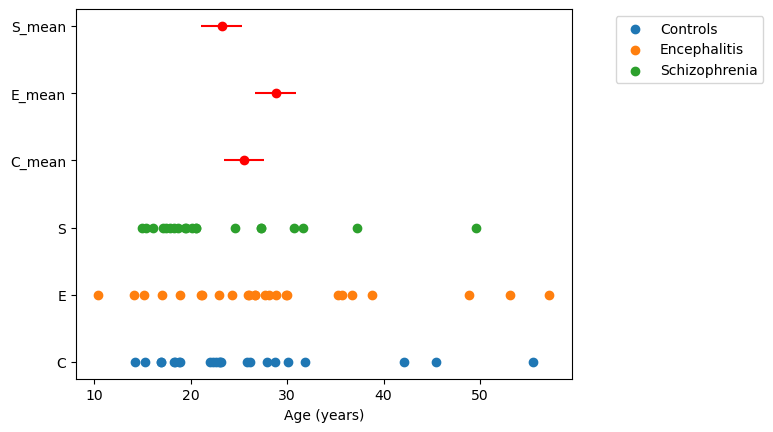

In [4]:
age['Group'] = age['Subject'].str[0]
age.tail(9)


# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
  
plt.errorbar(np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), "C_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']), "E_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']), "S_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')

plt.xlabel('Age (years)')
plt.savefig('Age variance', bbox_inches='tight')
plt.show()




In [5]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
#data = concatenated_df[crs1]
data=concatenated_df

# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')


# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F8', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
#chan_f = ['Fz','F3','F4']
chan_f = ['Fz','F3','F4','F7','F8']
data_fp['Position'] = 'P'
data_fp.loc[data_fp.Channel.isin(chan_f),'Position'] = 'F'
data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)


/tmp/ipykernel_4119281/3263902381.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'P'


## AGE COMPRISON between 20- and 20+

In [6]:
data_F = data_fp.copy()
data_F = data_F[data_F['Position'] == 'F'].reset_index(drop=True)
data_F.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
0  16147  0.390689  1406.81      1407.16  1407.77  1408.12      1.64   
1  11458  0.391044  1408.03      1408.31  1408.67  1409.26      1.50   
2  14355  0.393181  1415.75      1416.35  1416.68  1416.93      1.48   
3  11459  0.393536  1417.03      1417.28  1417.47  1417.69      0.96   
4  14356  0.397639  1431.74      1431.96  1432.18  1432.82      1.32   

   ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
0  -54.438037   56.538966  110.977003  317.077151   0.609756      2      F4   
1  -59.791872   41.681846  101.473718  362.406135   0.666667      2      F7   
2  -43.574775   38.377907   81.952683  136.587804   0.675676      2      Fz   
3  -82.223783   45.544797  127.768579  511.074318   1.041667      2      F7   
4  -42.860329   34.949432   77.809761  353.680731   0.757576      2      Fz   

   IdxChannel Group Subject Session    Age Machine ConfArousal Position  
0           9     C     C02       1  22.91       O           0        F  
1           6     C     C02       1  22.91       O           0        F  
2           8     C     C02       1  22.91       O           0        F  
3           6     C     C02       1  22.91       O           0        F  
4           8     C     C02       1  22.91       O           0        F

In [7]:
data_F[data_F['Stage'] == 3]['Start']

47        0.673000
48        0.679381
49        0.679381
50        0.679381
51        0.679381
            ...   
763658    5.718425
763659    5.722625
763660    5.722628
763661    5.722950
763849    6.576497
Name: Start, Length: 507419, dtype: float64

In [8]:
data_F['Start']

0         0.390689
1         0.391044
2         0.393181
3         0.393536
4         0.397639
            ...   
764294    7.966611
764295    7.966636
764296    7.971547
764297    7.982069
764298    7.982247
Name: Start, Length: 764299, dtype: float64

In [9]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

def first_block_all(data, data_n3, bin_size, threshold_sum):
    
    if len(data_n3) < threshold_sum:
         return None

    hist_values, bin_edges = np.histogram(data, bins=np.arange(0, round(max(data),2) + bin_size, bin_size))
    hist_valuesn3, bin_edgesn3 = np.histogram(data_n3, bins=np.arange(0, round(max(data_n3),2) + bin_size, bin_size))

    nz_indices = np.where(hist_values > 20)[0]
    nz_indices3 = np.where(hist_valuesn3 > 10)[0]

    nz_edges = np.round(bin_edges[nz_indices],2)
    nz_edges3 = np.round(bin_edgesn3[nz_indices3],2)

    cbins = [nz_edges3[0]]

    for i in range(1, len(nz_edges)): 
        if nz_edges[i] in nz_edges3 or nz_edges[i] > cbins[0]:
            if round(nz_edges[i] - nz_edges[i - 1],2) == bin_size:
                cbins.append(nz_edges[i])
            else:
                if (sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum):
                    return cbins[0]

                if nz_edges[i] in nz_edges3:
                    cbins = [nz_edges[i]]
            
    if sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum:
                return cbins[0]
    return None


data_starts = data_F.groupby('Id').apply(
    lambda x: first_block_all(
        data=x['Start'],
        data_n3=x[x['Stage'] == 3]['Start'],
        bin_size=0.05,
        threshold_sum=500
    )
).reset_index(name='Start_Block')




In [10]:
data_F['N3_times'] = data_F['Id'].map(data_starts.set_index('Id')['Start_Block'])


data_F['time_rel'] = data_F['Start'] - data_F['N3_times']
data_allF = data_F[(data_F['time_rel'] <= 0.6) & (data_F['time_rel'] >= 0)]
data_allF = data_allF[(data_allF['Stage'] == 3) | (data_allF['time_rel'] >= 0.2)]

data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

data_F['condBlock'] = 0
for index, row in data_F.iterrows():
    if row['Stage'] == 3:
        t0 = row['Start']
        t0_5 = t0 + 0.5
        id = row['Id']
        data_Id = data_F.where(data_F['Id'] == id)
        data_Id['N3'] = data_Id['Stage'].apply(lambda x: 1 if x == 3 else 0)
        c = data_Id[(data_Id['Start'] > t0) & (data_Id['Start'] <= t0_5)] 
        c = c['N3'].eq(1).sum()
        if c >= 100:
            row['condBlock'] = 1

In [11]:
result_df = data_allF.groupby('Id')['N3_times'].first().reset_index()
result_df[0:60]


Id  N3_times
0   C02_1      0.70
1   C03_1      2.30
2   C03_4      3.45
3   C04_1      0.25
4   C05_4      1.05
5   C06_1      0.40
6   C06_4      0.85
7   C07_4      1.20
8   C08_1      1.80
9   C08_4      0.50
10  C09_4      2.60
11  C10_1      0.25
12  C10_4      0.40
13  C11_1      0.50
14  C12_1      0.35
15  C13_1      0.85
16  C13_4      1.15
17  C14_1      0.75
18  C14_4      1.35
19  C15_1      0.90
20  C15_4      0.50
21  C16_1      1.65
22  C16_4      1.00
23  C17_1      0.30
24  C18_1      0.75
25  C20_1      1.20
26  C20_4      1.40
27  C21_1      2.85
28  C22_1      0.60
29  C23_1      0.90
30  C23_4      0.65
31  C24_1      0.95
32  E01_2      0.55
33  E01_3      0.80
34  E02_1      0.30
35  E02_2      0.35
36  E02_3      0.35
37  E02_4      0.40
38  E03_1      0.45
39  E03_2      0.50
40  E03_3      0.15
41  E03_4      0.45
42  E04_1      0.60
43  E04_2      0.45
44  E04_3      0.40
45  E04_4      0.35
46  E05_1      5.20
47  E05_2      1.25
48  E06_1      0.25
49  E07_1      0.10
50  E07_2      0.15
51  E07_3      0.15
52  E07_4      0.25
53  E08_2      0.55
54  E08_3      0.55
55  E08_4      0.85
56  E09_4      0.90
57  E10_3      1.05
58  E10_4      0.50
59  E11_1      0.25

In [12]:
data_allF[data_allF['Id'] == 'C02_1'].head(9)

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
55  14366  0.711431  2561.41      2561.65  2561.89  2562.17      1.02   
56  16157  0.711439  2561.44      2561.67  2561.92  2562.21      1.03   
57  11472  0.718289  2586.16      2586.47  2586.69  2587.44      1.60   
58  12771  0.718289  2586.20      2586.51  2586.74  2587.45      1.61   
59  16158  0.718289  2586.21      2586.55  2586.80  2587.41      1.57   
60  17692  0.718289  2586.19      2586.53  2586.87  2587.36      1.52   
61  16159  0.722950  2602.98      2603.20  2603.48  2603.80      1.18   
62  14367  0.728472  2622.79      2623.03  2623.25  2623.97      1.47   
63  16160  0.730631  2630.59      2630.83  2631.04  2631.30      1.03   

    ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
55  -43.055807   39.801527   82.857334  345.238892   0.980392      3      Fz   
56  -41.747439   44.001763   85.749202  372.822617   0.970874      3      F4   
57  -67.717177   20.232169   87.949346  283.707569   0.625000      3      F7   
58 -103.667240   46.635767  150.303006  484.848408   0.621118      3      F3   
59  -91.779559   43.404657  135.184215  397.600633   0.636943      3      F4   
60  -49.231720   26.332969   75.564689  222.249086   0.657895      3      F8   
61  -62.086992   91.715645  153.802637  699.102896   0.847458      3      F4   
62  -45.009583   36.084354   81.093936  337.891401   0.680272      3      Fz   
63  -90.122824   65.240226  155.363050  647.346042   0.970874      3      F4   

    IdxChannel Group Subject Session    Age Machine ConfArousal Position  \
55           8     C     C02       1  22.91       O           0        F   
56           9     C     C02       1  22.91       O           0        F   
57           6     C     C02       1  22.91       O           0        F   
58           7     C     C02       1  22.91       O           0        F   
59           9     C     C02       1  22.91       O           0        F   
60          10     C     C02       1  22.91       O           0        F   
61           9     C     C02       1  22.91       O           0        F   
62           8     C     C02       1  22.91       O           0        F   
63           9     C     C02       1  22.91       O           0        F   

       Id  N3_times  time_rel  
55  C02_1       0.7  0.011431  
56  C02_1       0.7  0.011439  
57  C02_1       0.7  0.018289  
58  C02_1       0.7  0.018289  
59  C02_1       0.7  0.018289  
60  C02_1       0.7  0.018289  
61  C02_1       0.7  0.022950  
62  C02_1       0.7  0.028472  
63  C02_1       0.7  0.030631

In [13]:

#SEPARATE BINNED DATA_F in 20- and 20+

bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  # Adjust the number of bins as needed


print (len(bins_data_F))

#older group
bdf_o = bins_data_F[bins_data_F['Age'] >= 20]
print(len(bdf_o))

bdf_o = bdf_o.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_o['Group'] = bdf_o['Subject'].str[0]
mdf_o = bdf_o.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#younger group
bdf_y = bins_data_F[bins_data_F['Age'] < 20]
print(len(bdf_y))

bdf_y = bdf_y.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_y['Group'] = bdf_y['Subject'].str[0]
mdf_y = bdf_y.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#all
bins_data_F = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bins_data_F['Group'] = bins_data_F['Subject'].str[0]
mean_data_F = bins_data_F.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


102047
45998
56049


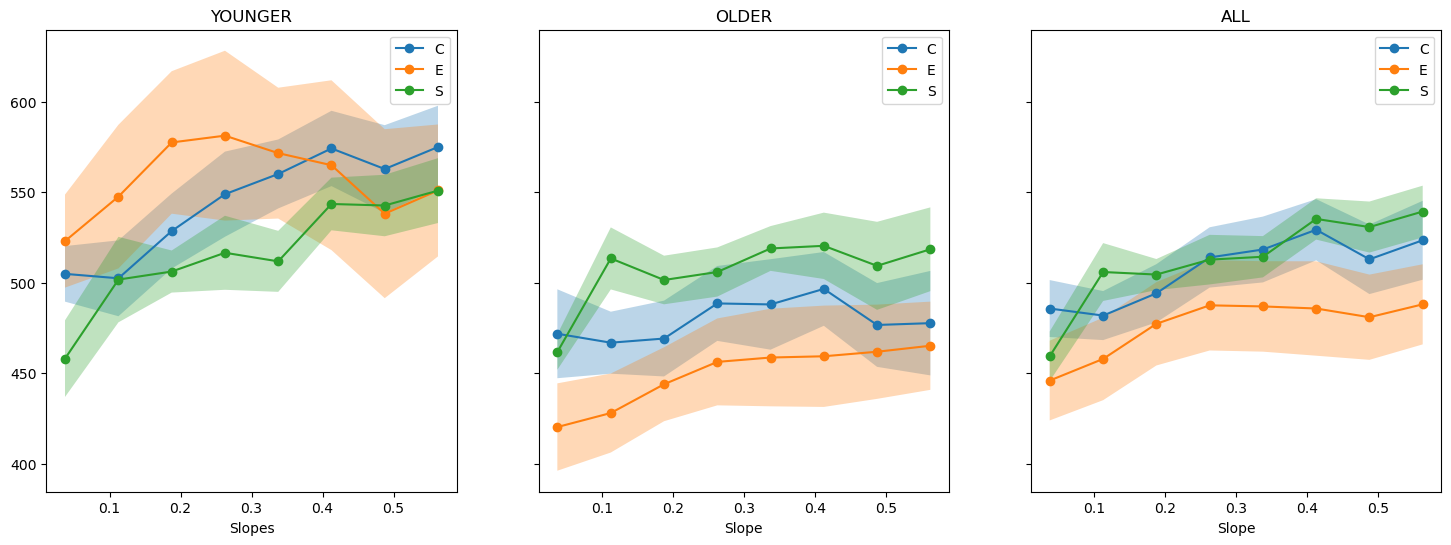

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6), sharex = 'all', sharey = 'all')

# Plot the individual curves for each name
mdf_o["time_rel_c"] = mdf_o["time_rel"].apply(lambda x: x.mid)
mdf_y["time_rel_c"] = mdf_y["time_rel"].apply(lambda x: x.mid)
mean_data_F["time_rel_c"] = mean_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = mdf_o['time_rel_c'].unique()

#YOUNGER
ax[0].set_title('YOUNGER')
for name, group in mdf_y.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].set_xlabel('Time')
ax[0].set_xlabel('Slopes')
ax[0].legend()

#OLDER
ax[1].set_title('OLDER')
for name, group in mdf_o.groupby('Group'):
    ax[1].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[1].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[1].set_xlabel('Time')
ax[1].set_xlabel('Slope')
ax[1].legend()

#ALL
ax[2].set_title('ALL')
for name, group in mean_data_F.groupby('Group'):
    ax[2].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[2].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[2].set_xlabel('Time')
ax[2].set_xlabel('Slope')
ax[2].legend()



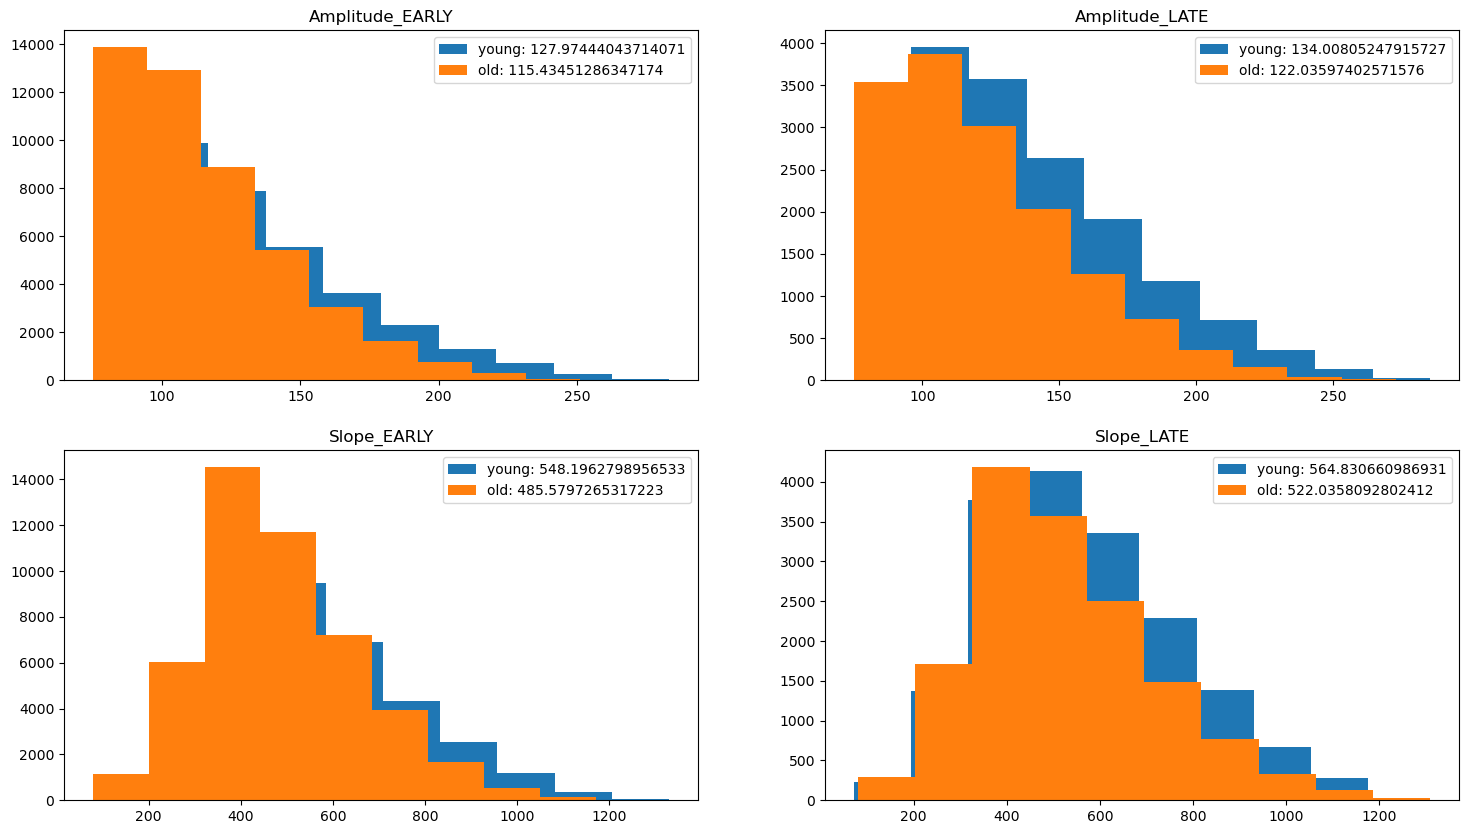

In [15]:
fig, ax = plt.subplots(2, 2, figsize = (18, 10))


data_young = data_allF[data_allF['Age'] < 20]
data_old = data_allF[data_allF['Age'] >= 20]


data_early_young = data_young[data_young['time_rel'] <= 0.3]
data_late_young = data_young[data_young['time_rel'] >= 0.5]
data_early_old = data_old[data_old['time_rel'] <= 0.3]
data_late_old = data_old[data_old['time_rel'] >= 0.5]


ax[0,0].hist(data_early_young.PTP, label = 'young: ' + str(np.mean(data_early_young.PTP)) )
ax[0,0].hist(data_early_old.PTP, label = 'old: ' + str(np.mean(data_early_old.PTP)))
ax[0,0].set_title('Amplitude_EARLY')
ax[0,0].legend()

ax[0,1].hist(data_late_young.PTP, label = 'young: ' + str(np.mean(data_late_young.PTP)) )
ax[0,1].hist(data_late_old.PTP, label = 'old: ' + str(np.mean(data_late_old.PTP)))
ax[0,1].set_title('Amplitude_LATE')
ax[0,1].legend()

ax[1,0].hist(data_early_young.Slope, label = 'young: ' + str(np.mean(data_early_young.Slope)) )
ax[1,0].hist(data_early_old.Slope, label = 'old: ' + str(np.mean(data_early_old.Slope)))
ax[1,0].set_title('Slope_EARLY')
ax[1,0].legend()

ax[1,1].hist(data_late_young.Slope, label = 'young: ' + str(np.mean(data_late_young.Slope)) )
ax[1,1].hist(data_late_old.Slope, label = 'old: ' + str(np.mean(data_late_old.Slope)))
ax[1,1].set_title('Slope_LATE')
ax[1,1].legend()


     Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
55  14366  0.711431  2561.41      2561.65  2561.89  2562.17      1.02   
56  16157  0.711439  2561.44      2561.67  2561.92  2562.21      1.03   
57  11472  0.718289  2586.16      2586.47  2586.69  2587.44      1.60   
58  12771  0.718289  2586.20      2586.51  2586.74  2587.45      1.61   
59  16158  0.718289  2586.21      2586.55  2586.80  2587.41      1.57   

    ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
55  -43.055807   39.801527   82.857334  345.238892   0.980392      3      Fz   
56  -41.747439   44.001763   85.749202  372.822617   0.970874      3      F4   
57  -67.717177   20.232169   87.949346  283.707569   0.625000      3      F7   
58 -103.667240   46.635767  150.303006  484.848408   0.621118      3      F3   
59  -91.779559   43.404657  135.184215  397.600633   0.636943      3      F4   

    IdxChannel Group Subject Session    Age Machine ConfArousal Position  \
55  

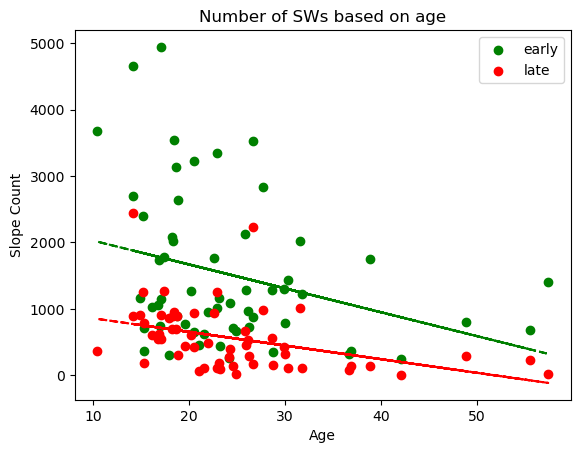

In [16]:

x_early_list = []
y_early_list = []
x_late_list = []
y_late_list = []

for name, Subject in data_allF.groupby('Subject'):
    data_early = Subject[Subject['time_rel'] <= 0.3]
    data_late = Subject[Subject['time_rel'] >= 0.5]

    print(data_early[0:5])

    x_early_list.append(Subject['Age'].unique()[0])
    y_early_list.append(data_early['Slope'].count())

    x_late_list.append(Subject['Age'].unique()[0])
    y_late_list.append(data_late['Slope'].count())

plt.scatter(x_early_list, y_early_list, marker='o', c='green', label='early')
plt.scatter(x_late_list, y_late_list, marker='o', c='red', label='late')

print(len(x_early_list))

early_fit = np.polyfit(x_early_list, y_early_list, 1)
late_fit = np.polyfit(x_late_list, y_late_list, 1)

plt.plot(x_early_list, np.polyval(early_fit, x_early_list), color='green', linestyle='--')
plt.plot(x_late_list, np.polyval(late_fit, x_late_list), color='red', linestyle='--')

plt.title('Number of SWs based on age')
plt.xlabel('Age')
plt.ylabel('Slope Count')
plt.legend()
plt.show()



# Age modelling for controls

In [17]:
bdf_c = data_allF.copy()
bdf_c = bdf_c[bdf_c['Group']=='C']
bdf_c.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
55  14366  0.711431  2561.41      2561.65  2561.89  2562.17      1.02   
56  16157  0.711439  2561.44      2561.67  2561.92  2562.21      1.03   
57  11472  0.718289  2586.16      2586.47  2586.69  2587.44      1.60   
58  12771  0.718289  2586.20      2586.51  2586.74  2587.45      1.61   
59  16158  0.718289  2586.21      2586.55  2586.80  2587.41      1.57   

    ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
55  -43.055807   39.801527   82.857334  345.238892   0.980392      3      Fz   
56  -41.747439   44.001763   85.749202  372.822617   0.970874      3      F4   
57  -67.717177   20.232169   87.949346  283.707569   0.625000      3      F7   
58 -103.667240   46.635767  150.303006  484.848408   0.621118      3      F3   
59  -91.779559   43.404657  135.184215  397.600633   0.636943      3      F4   

    IdxChannel Group Subject Session    Age Machine ConfArousal Position  \
55           8     C     C02       1  22.91       O           0        F   
56           9     C     C02       1  22.91       O           0        F   
57           6     C     C02       1  22.91       O           0        F   
58           7     C     C02       1  22.91       O           0        F   
59           9     C     C02       1  22.91       O           0        F   

       Id  N3_times  time_rel  
55  C02_1       0.7  0.011431  
56  C02_1       0.7  0.011439  
57  C02_1       0.7  0.018289  
58  C02_1       0.7  0.018289  
59  C02_1       0.7  0.018289

In [18]:
# Obtain first hour of SWS:

#BINS DATA FRAME _ CONTROLS

bdf_c = data_allF.copy()
bdf_c = bdf_c[bdf_c['Group']=='C']
bdf_c['time_rel'] = pd.cut(bdf_c['time_rel'], bins=8)  # Adjust the number of bins as needed
print(len(bdf_c['Id'].unique()))

bdf_c = bdf_c.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_c['Group'] = bdf_c['Subject'].str[0]

age_c = age[age['Group']=='C']
#age_c = age_c[age_c['Session']==1]

bdf_c = bdf_c.merge(age_c)
bdf_c.head()


32


Session Subject          time_rel       Slope Group            Birthdate  \
0        1     C02  (-0.0006, 0.075]  437.661771     C  1994-05-28 00:00:00   
1        1     C02     (0.075, 0.15]  452.042341     C  1994-05-28 00:00:00   
2        1     C02     (0.15, 0.225]  470.856149     C  1994-05-28 00:00:00   
3        1     C02      (0.225, 0.3]  509.915440     C  1994-05-28 00:00:00   
4        1     C02      (0.3, 0.375]  560.111017     C  1994-05-28 00:00:00   

              Testdate    Age  
0  2017-04-26 00:00:00  22.91  
1  2017-04-26 00:00:00  22.91  
2  2017-04-26 00:00:00  22.91  
3  2017-04-26 00:00:00  22.91  
4  2017-04-26 00:00:00  22.91

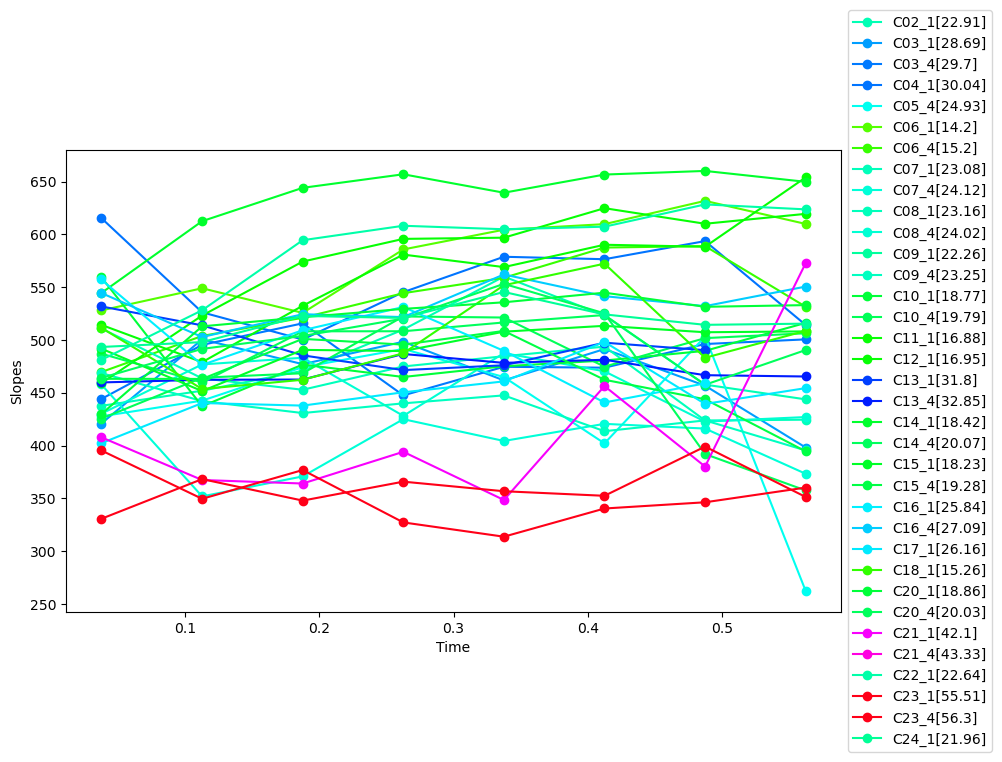

In [19]:

plt.figure(figsize=(10, 6))

# Plot the individual curves for each age

bdf_c["time_rel_c"] = bdf_c["time_rel"].apply(lambda x: x.mid).astype('object')
time_intervals = bdf_c['time_rel_c'].unique()
bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
for name, Id in bdf_c.groupby('Id'):
    plt.plot(time_intervals, Id['Slope'], marker='o', c = cm.hsv(Id['Age'].unique()[0]/50), label=str(name) + str(Id['Age'].unique()))

plt.xlabel('Time')
plt.ylabel('Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



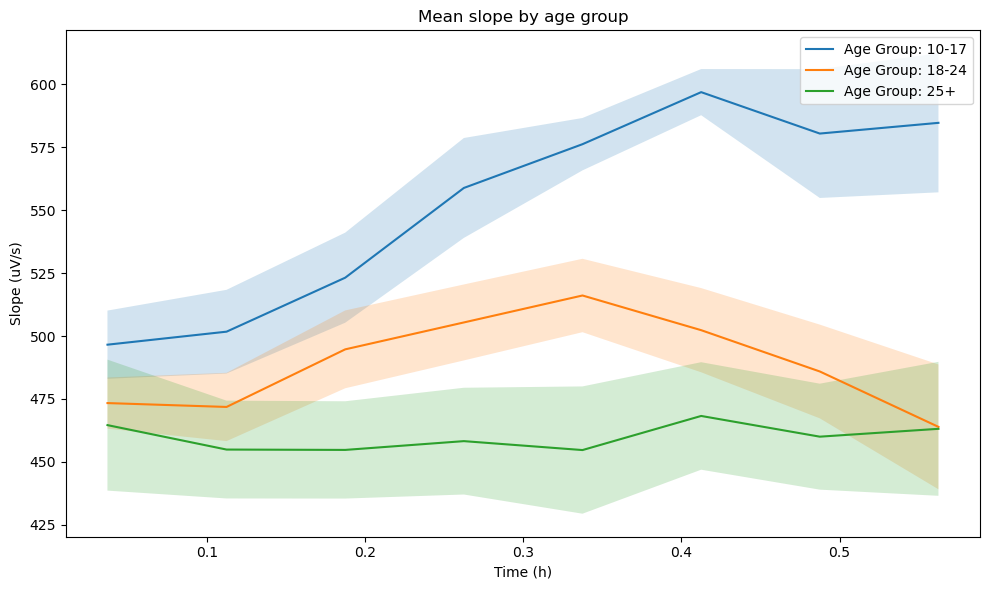

In [42]:
bins = [10, 18, 25, np.inf]
labels = ['10-17','18-24','25+']
bdf_c['age_group'] = pd.cut(bdf_c['Age'], bins=bins, labels=labels, right=False)

# Plotting
plt.figure(figsize=(10, 6))

for age_group, group_data in bdf_c.groupby('age_group'):
    mean_score = group_data.groupby('time_rel_c')['Slope'].mean()
    sem_score = group_data.groupby('time_rel_c')['Slope'].sem()
    plt.plot(time_intervals, mean_score.values, label=f'Age Group: {age_group}')
    plt.fill_between(mean_score.index, mean_score - sem_score, mean_score + sem_score, alpha=0.2)


plt.xlabel('Time (h)')
plt.ylabel('Slope (uV/s)')
plt.title('Mean slope by age group')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50
print(len(daf_c['Id'].unique()))

32


[]

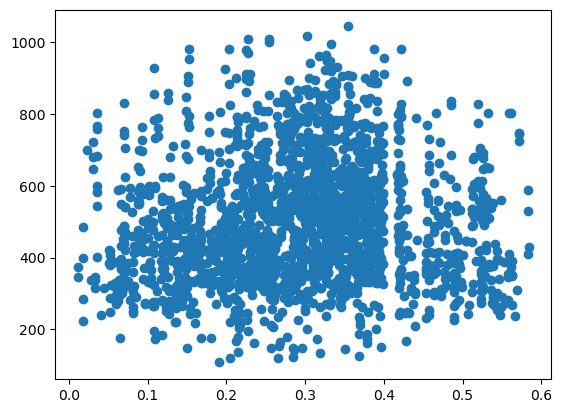

In [22]:
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
daf_c = daf_c[daf_c['Id'] == 'C02_1']
plt.scatter(daf_c.time_rel,daf_c.Slope)
plt.plot()


[0.01143056 0.01143889 0.01828889 ... 0.58251944 0.58251944 0.58383056]
[345.238892   372.82261687 283.70756876 ... 588.40256265 409.66118335
 429.41022375]


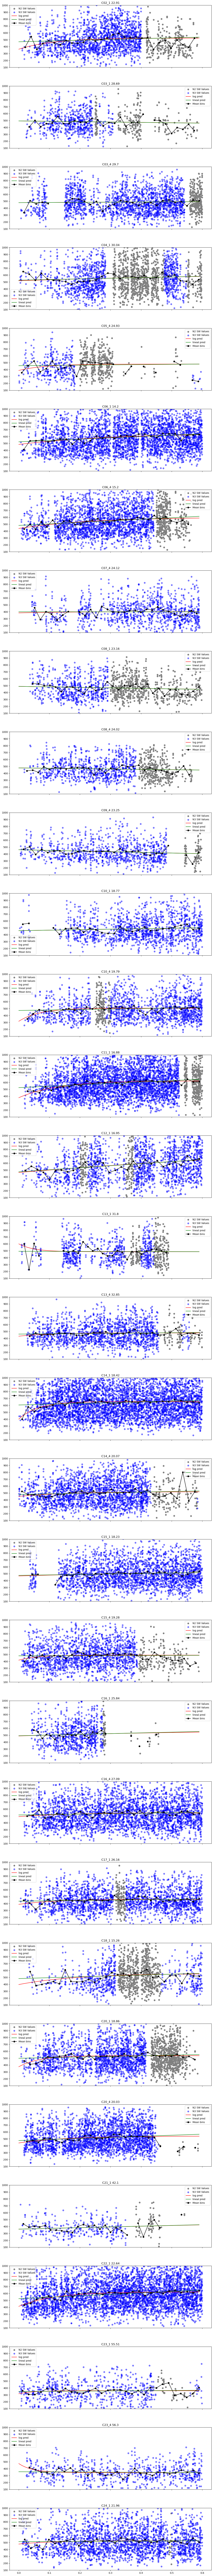

In [23]:

#LOG NO BINS
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50

def func(x, a, b, c):
    return a - (b * np.exp(-x/c))

def func_l(x, m,n):
    return m + n*x


x_list = []
a_list = []
b_list = []
c_list = []

m_list = []
n_list = []

# Get the number of subplots needed
num_subplots = len(daf_c['Id'].unique())

# Create a figure and subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 6*num_subplots),sharex=True, gridspec_kw={'hspace': 0.3})

for idx, (name, Subject) in enumerate(daf_c.groupby('Id')):

    x = Subject.time_rel.values
    y = Subject.Slope.values

    if name == 'C02_1':
        print(x)
        print(y)

    popt, pcov = curve_fit(func, x, y, bounds=([0, -1000, 0], [1000, 1000, 5]))

    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

    poptl, pcovl = curve_fit(func_l, x, y, bounds=([0, -1000], [1000, 1000]))

    coef_m = popt[0]
    coef_n = popt[1]


    m_list.append(coef_m)
    n_list.append(coef_n)



    # Plot on the respective subplot
    x_time = np.arange(0,0.6,0.01)
    Subject_2 = Subject[Subject['Stage']==2]
    Subject_3 = Subject[Subject['Stage']==3]
    axs[idx].scatter(Subject_2.time_rel.values, Subject_2.Slope.values,c='gray',label='N2 SW Values')
    axs[idx].scatter(Subject_3.time_rel.values, Subject_3.Slope.values,c='blue',label='N3 SW Values', alpha=0.5)
    axs[idx].plot(x_time, func(x_time, popt[0], popt[1], popt[2]), color='red', label='log pred')
    axs[idx].plot(x_time, func_l(x_time, poptl[0], poptl[1]), color='green', label='lineal pred')
    axs[idx].set_title(name + ' ' + str(Subject['Age'].unique()[0]))
    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=30)
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid)
    time_intervals = bins_Subject['time_rel_c'].unique()
    axs[idx].plot(time_intervals, bins_Subject['Slope'], marker='o', c = 'black', label='Mean bins')
    axs[idx].set_ylim([100,1000])
    axs[idx].legend()


plt.show()
        



In [24]:
Subject.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
192210  10360  0.959689  3455.58      3455.79  3456.01  3456.26      1.38   
192211  10361  0.962000  3463.45      3463.62  3463.84  3464.04      0.84   
192212   8898  0.962006  3463.46      3463.64  3463.84  3464.03      0.81   
192213   8068  0.962008  3463.46      3463.65  3463.85  3464.03      0.80   
192214   8069  0.962231  3464.24      3464.46  3464.65  3464.92      0.89   

        ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
192210  -41.726678   39.928186   81.654864  388.832686   0.724638      3   
192211  -56.612415   90.402405  147.014820  864.793056   1.190476      3   
192212  -70.476641   86.176969  156.653610  870.297832   1.234568      3   
192213  -45.617400   47.159803   92.777203  488.301067   1.250000      3   
192214  -52.927509   34.128455   87.055964  395.708926   1.123596      3   

       Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
192210      Fz           8     C     C24       1  21.96       O           0   
192211      Fz           8     C     C24       1  21.96       O           0   
192212      F3           7     C     C24       1  21.96       O           0   
192213      F7           6     C     C24       1  21.96       O           0   
192214      F7           6     C     C24       1  21.96       O           0   

       Position     Id  N3_times  time_rel    sAge  
192210        F  C24_1      0.95  0.009689  0.4392  
192211        F  C24_1      0.95  0.012000  0.4392  
192212        F  C24_1      0.95  0.012006  0.4392  
192213        F  C24_1      0.95  0.012008  0.4392  
192214        F  C24_1      0.95  0.012231  0.4392

 _____________ Fitted Parameters So:
M: 565.4892568716236
N: -3.6098700240264643
 _____________ Fitted Parameters St:
a: 17.681748501018795
b: -4710.926061614221
c: 4.621059406236822
[[ 7.84216804e+02 -1.46059975e+05 -4.92584527e+01]
 [-1.46059975e+05  5.67609927e+07  1.71240708e+04]
 [-4.92584527e+01  1.71240708e+04  5.27743443e+00]]


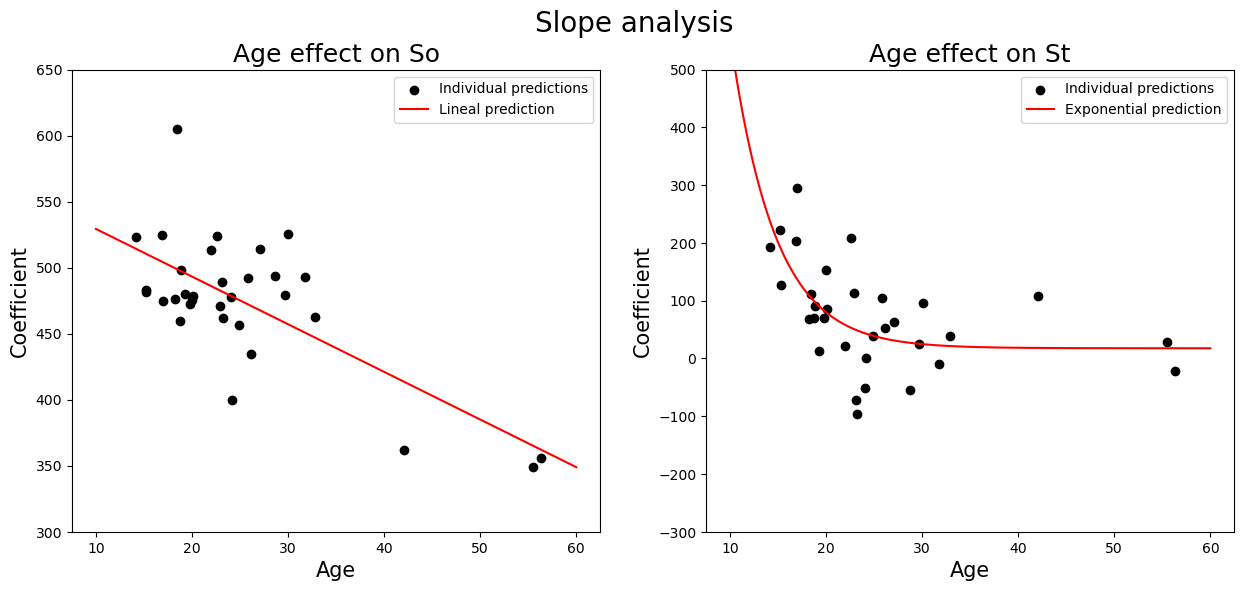

In [47]:
#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func_l(x, m, n):
    return m + n*x

def func_exp(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
m_list = []
n_list = []


for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values
      
    popt, pcov = curve_fit(func_l, x, y,bounds=([0,-1000],[1000,1000]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_m = popt[0]
    coef_n = popt[1]

    x_list.append(Subject['Age'].unique()[0])
    m_list.append(coef_m)
    n_list.append(coef_n)

fig, ax = plt.subplots(1, 2, figsize = (15, 6))

splot = 0
coef_names = ['So','St']
total_coefs = []

for coef_list in [m_list,n_list]:
    y_list = coef_list

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)

    if splot == 0:
        
        popt_t, pcov_t = curve_fit(func_l, x_sorted, y_sorted,bounds=([0,-1000],[1000,1000]))

        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("M:", popt_t[0])
        print("N:", popt_t[1])

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])


        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_l(x_ages, popt_t[0], popt_t[1]), c='red', label='Lineal prediction')

    else: 
        popt_t, pcov_t,info, mesg,ier= curve_fit(func_exp, x_sorted, y_sorted, bounds=([-10000, -15000, 0], [10000, 0, 1000]), full_output=True)


        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("a:", popt_t[0])
        print("b:", popt_t[1])
        print("c:", popt_t[2])
        print(pcov_t)

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])
        total_coefs.append(popt_t[2])
    

        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_exp(x_ages, popt_t[0], popt_t[1], popt_t[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot],fontsize=18)
    ax[splot].set_xlabel('Age',fontsize=15)
    ax[splot].set_ylabel('Coefficient',fontsize=15)


    if splot == 0:
        ax[splot].set_ylim([300,650])
    else:
        ax[splot].set_ylim([-300,500])

    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=20)
plt.savefig('Age model', bbox_inches='tight')
plt.show()



In [26]:
print(total_coefs)

[565.4892568716236, -3.6098700240264643, 17.681748501018795, -4710.926061614221, 4.621059406236822]


In [27]:
age

Subject  Session            Birthdate             Testdate    Age Group
0       C02        1  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91     C
1       C03        1  1988-09-09 00:00:00  2017-05-18 00:00:00  28.69     C
2       C04        1  1987-05-24 00:00:00  2017-06-08 00:00:00  30.04     C
3       C06        1  2003-04-10 00:00:00  2017-06-22 00:00:00  14.20     C
4       C07        1  1994-06-05 00:00:00  2017-07-05 00:00:00  23.08     C
..      ...      ...                  ...                  ...    ...   ...
131     S07        4  2002-06-21 00:00:00  2019-03-28 00:00:00  16.77     S
132     S08        4  2003-05-09 00:00:00  2019-03-27 00:00:00  15.88     S
133     S11        4  2003-05-15 00:00:00  2019-11-07 00:00:00  16.48     S
134     S12        4  1998-03-04 00:00:00  2019-09-05 00:00:00  21.51     S
135     S15        4  2000-06-18 00:00:00  2020-02-20 00:00:00  19.67     S

[136 rows x 6 columns]

102047


[]

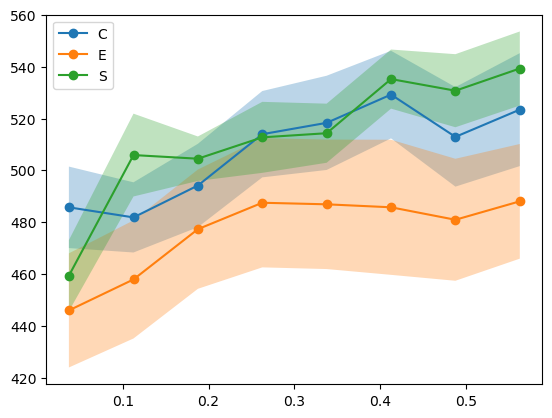

In [28]:
bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

mdf = bdf.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


for name, group in mdf.groupby('Group'):
    plt.plot(time_intervals, group['mean'], marker='o', label=name)
    plt.fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)
plt.legend()
plt.plot()



102047


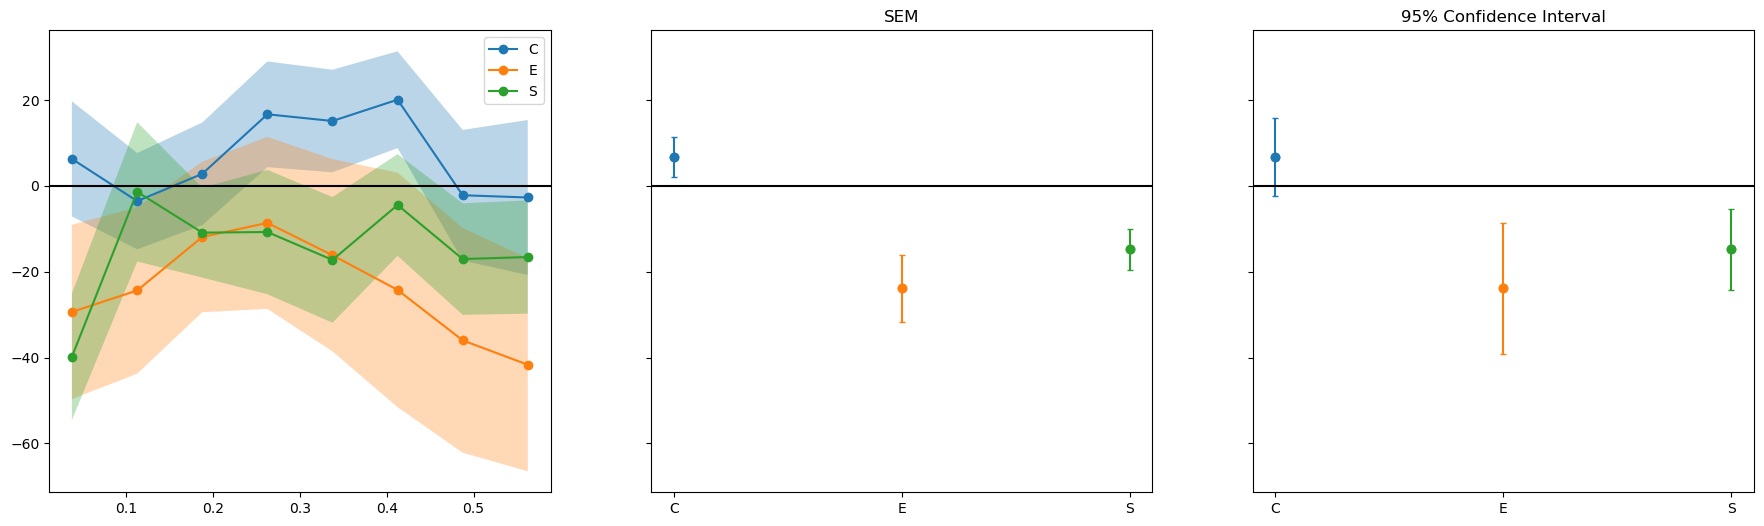

In [29]:
bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

bdf['Age'] = pd.to_numeric(bdf['Age'], errors='coerce')
bdf['time_rel_c'] = pd.to_numeric(bdf['time_rel_c'], errors='coerce')

bdf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * bdf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-bdf['Age'] / total_coefs[4])) * bdf['time_rel_c']
)

bdf['Slope_rel'] = bdf['Slope'] - bdf['Slope_n']

mdf = bdf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()
mdf_t = bdf.groupby(['Group'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [30]:
model = Lmer('Slope_rel ~ time_rel_c*Age*Group + (1|Subject)', data=bdf)
model.fit()



print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "time_rel". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Birthdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Testdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while trying to convert '


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel_c*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 392	 Groups: {'Subject': 49.0}

Log-likelihood: -1997.059 	 AIC: 4022.119

Random effects:

                 Name       Var     Std
Subject   (Intercept)  3041.140  55.147
Residual               1431.093  37.830

No random effect correlations specified

Fixed effects:

                         Estimate      2.5_ci     97.5_ci          SE  \
(Intercept)             14.646011  -59.797101   89.089124   37.981878   
time_rel_c             -37.588426 -132.112129   56.935278   48.227265   
Age                     -0.343932   -3.149219    2.461354    1.43

In [31]:
# DATA

# x is a matrix one column per participant, one row per time  70 * 8
# age is a vector of 70 * 1 values
# group is a matrix of one column per participant, 70 * 3 rows (is_control, is_enc, is_sq)

# X is a matrix with all data above:  70 * 12(8+1+3) 

# PARAMETERS
# mi is a vector of 70 values
# mage is a scalar
# mgroup is a vector of 3 values (control, enc, sq)


# Y = 8*70



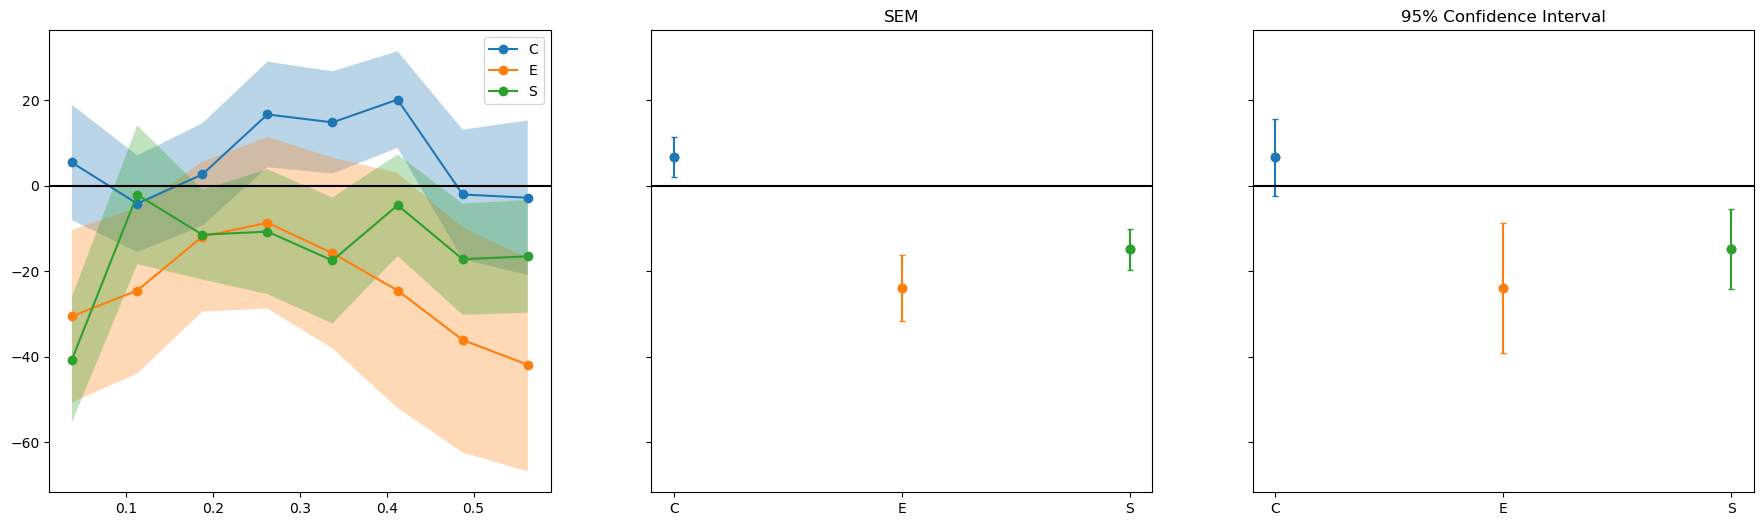

In [32]:
daf = data_allF.copy()
daf = daf[daf['Session']==1]
daf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * daf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-daf['Age'] / total_coefs[4])) * daf['time_rel']
)

daf['Slope_rel'] = daf['Slope'] - daf['Slope_n']
bdaf = daf.copy()
bdaf['time_rel'] = pd.cut(bdaf['time_rel'], bins=8)  
bdaf = bdaf.groupby(['Session','Subject','time_rel'])['Slope_rel'].mean().reset_index()
bdaf['Group'] = bdaf['Subject'].str[0]
bdaf["time_rel_c"] = bdaf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdaf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdaf = bdaf.merge(age)

bdaf['Age'] = pd.to_numeric(bdaf['Age'], errors='coerce')
bdaf['time_rel_c'] = pd.to_numeric(bdaf['time_rel_c'], errors='coerce')

mdaf = bdaf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdaf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [33]:
mdaf.head()


Group            time_rel       mean        sem
0     C  (-0.000555, 0.075]   5.455637  13.473858
1     C       (0.075, 0.15]  -4.167279  11.291333
2     C       (0.15, 0.225]   2.654213  11.965526
3     C        (0.225, 0.3]  16.688186  12.335462
4     C        (0.3, 0.375]  14.832678  11.946875

In [34]:
mdf.head()


Group            time_rel       mean        sem
0     C  (-0.000555, 0.075]   6.283877  13.420655
1     C       (0.075, 0.15]  -3.572277  11.215999
2     C       (0.15, 0.225]   2.800400  11.955332
3     C        (0.225, 0.3]  16.660189  12.316459
4     C        (0.3, 0.375]  15.101058  11.945700

In [35]:
model = Lmer('Slope_rel ~ time_rel*Age*Group + (1|Subject)', data=daf)
model.fit()


print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 102047	 Groups: {'Subject': 49.0}

Log-likelihood: -675997.468 	 AIC: 1352022.935

Random effects:

                 Name        Var      Std
Subject   (Intercept)   3467.711   58.887
Residual               33157.499  182.092

No random effect correlations specified

Fixed effects:

                       Estimate      2.5_ci     97.5_ci         SE  \
(Intercept)           12.857097  -59.875303   85.589496  37.109049   
time_rel               4.024632  -36.682429   44.731693  20.769290   
Age                   -0.477801   -3.231850    2.276248   1.405153   
GroupE                23.651038  -88.336729  135.638805  57.137666   
GroupS              -110.128707 -277.153689   56.896275  85.218393   
time_rel:Age           1.178754   -0.660307    3.017814   0.938313   
time_rel:GroupE     -297.229609 -356.121567 -238.337652  30.047469 

In [36]:
bdf.head()



Session Subject            time_rel       Slope Group  time_rel_c  \
0        1     C02  (-0.000555, 0.075]  437.661771     C    0.037222   
1        1     C02       (0.075, 0.15]  452.042341     C    0.112500   
2        1     C02       (0.15, 0.225]  470.856149     C    0.187500   
3        1     C02        (0.225, 0.3]  509.915440     C    0.262500   
4        1     C02        (0.3, 0.375]  560.111017     C    0.337500   

             Birthdate             Testdate    Age     Slope_n  Slope_rel  
0  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  484.677813 -47.016042  
1  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  488.501455 -36.459115  
2  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  492.311002 -21.454853  
3  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  496.120549  13.794891  
4  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  499.930097  60.180920

 _____________ Fitted Parameters A:
a: -6777.154507836221
b: -7546.661168383346
c: 999.9999986521661
 _____________ Fitted Parameters B:
a: -3262.848229249959
b: -3490.8684783842614
c: 999.9999999999994
 _____________ Fitted Parameters C:
a: -33.44734754173034
b: -36.2215779568377
c: 999.9999999999995


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Slope analysis')

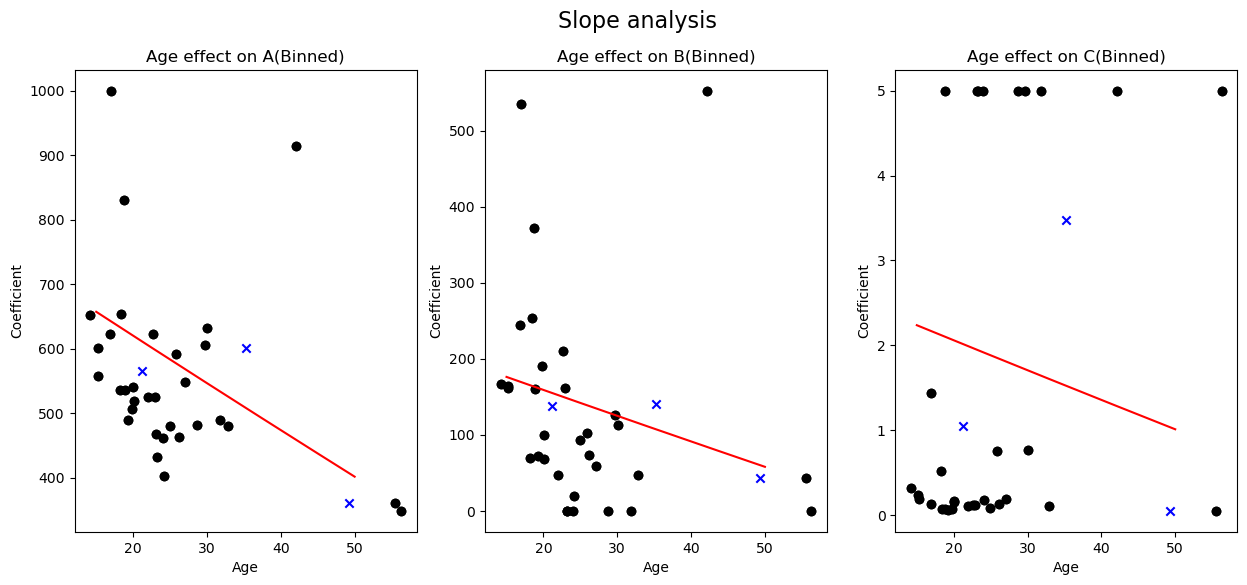

In [37]:

#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c)) 




x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]
    

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)
   

fig, ax = plt.subplots(1, 3, figsize = (15, 6))


splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 3
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])
    


    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=16)



/tmp/ipykernel_4119281/3904100052.py:66: RuntimeWarning: Mean of empty slice.
  bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: array must not contain infs or NaNs

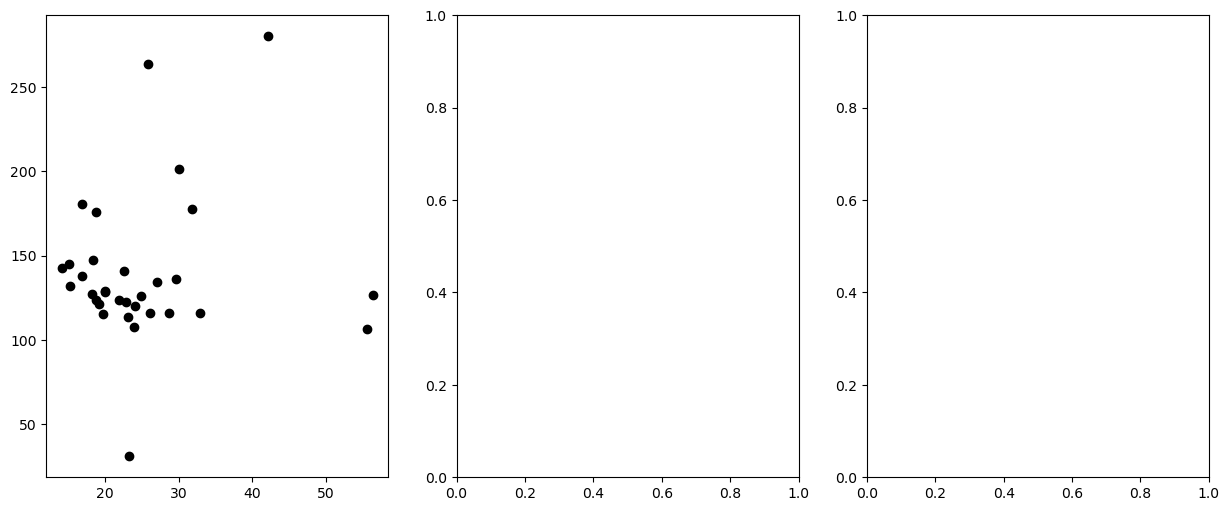

In [38]:
#LOG NO BINS AMPLITUDE


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.PTP.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,-1000,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)


 _____________ Fitted Parameters A:
a: 334.9040782477771
b: -4406.184268456695
c: 5.867572042923727
 _____________ Fitted Parameters B:
a: 274.59478448567137
b: -5419.125655398072
c: 6.027382406313883
 _____________ Fitted Parameters C:
a: -13.176671339495577
b: -13.876082661935177
c: 999.99999999961


Text(0.5, 0.98, 'Amplitude analysis')

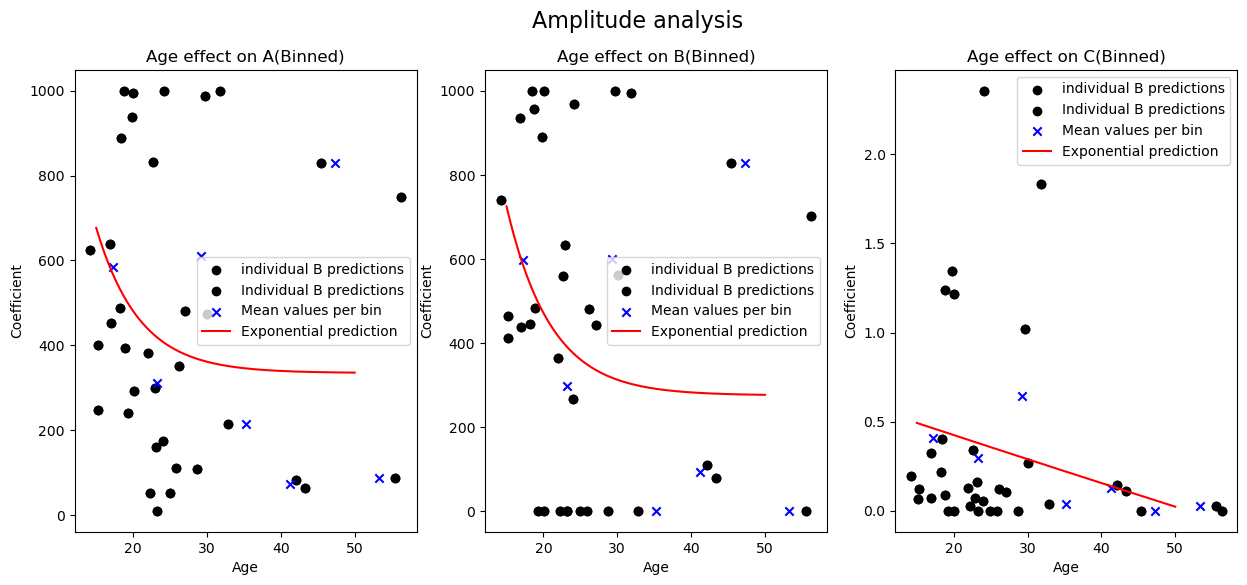

In [ ]:
#LOG NO BINS NUMBER


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)

    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=8)  # Adjust the number of bins as needed
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].count().reset_index()
    bdf_c['Group'] = bdf_c['Subject'].str[0]
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid).astype('object')
    times_Subject = bins_Subject['time_rel_c'].unique()
    
    x = bins_Subject.time_rel_c.values
    y = bins_Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    if popt[2] > 4:
        popt[2] = 0

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)

NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN


/tmp/ipykernel_2404168/2289991859.py:16: RuntimeWarning: overflow encountered in exp
  return a  + (b * np.exp(-x/c))


[]

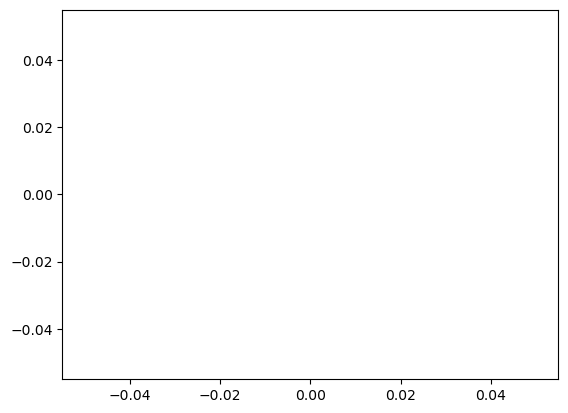

In [ ]:
#LOG WITH BINS




#CONTROL SWA found

bdf_c = bdf_c

bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
bdf_c['sAge'] = bdf_c['Age']/50


def func(x, a, b, c):

    return a  + (b * np.exp(-x/c))


for name, Subject in bdf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel_c.values
    y = Subject.Slope.values
    
    try:
        popt, pcov = curve_fit(func, x, y)
    

        #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
        coef = popt[1]
        #age = Subject['sAge'].unique()[0]
        plt.scatter(age,coef, color='black')

    except:
        print('NAN')

    #print(Subject['sAge'].unique()[0])
    #print(coef)
   
    
    
plt.plot()

C25_1
[0.037214 0.11249999999999999 0.1875 0.2625 0.3375 0.4125
 0.48750000000000004 0.5625]
524.6312083408473
-36.83694223891581
0.1114008015903066


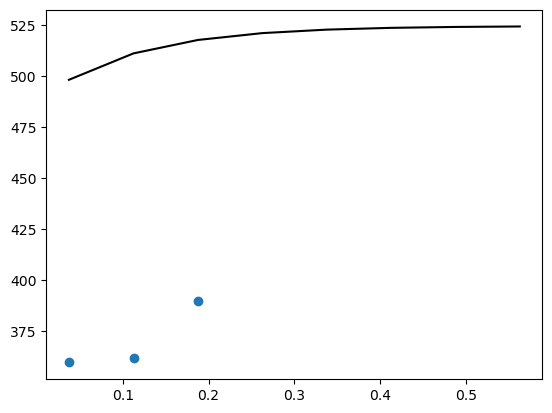

In [ ]:
print(name)
plt.scatter(Subject.time_rel_c,Subject.Slope.values)
print(x)
print(popt[0])
print(popt[1])
print(popt[2])
x = Subject.time_rel_c.values.astype(float)
plt.plot(x, func(x,popt[0],popt[1],popt[2]), color='black')

## SQRT PRED PLOT

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]

daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ sqrt_t', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ sqrt_t * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ sqrt_t * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()





IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## LINE PRED PLOT

/tmp/ipykernel_2747101/2835078309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2835078309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50
/tmp/ipykernel_2747101/2835078309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2047	 R^2: 0.001	 R^2_adj: 0.000

Log-likelihood: -13446.054 	 AIC: 26896.108	 BIC: 26907.356

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 902	 R^2: 0.003	 R^2_adj: 0.001

Log-likelihood: -5807.964 	 AIC: 11619.929	 BIC: 11629.538

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 466	 R^2: 0.003	 R^2_adj: 0.000

Log-likelihood: -2972.719 	 AIC: 5949.438	 BIC: 5957.726

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2500	 R^2: 0.002	 R^2_adj: 0.001

Log-likelihood: -16762.757 	 AIC: 33529.515	 BI

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1130	 R^2: 0.000	 R^2_adj: -0.001

Log-likelihood: -7311.558 	 AIC: 14627.116	 BIC: 14637.176

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1701	 R^2: 0.001	 R^2_adj: 0.001

Log-likelihood: -10866.761 	 AIC: 21737.521	 BIC: 21748.399

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 4434	 R^2: 0.024	 R^2_adj: 0.024

Log-likelihood: -29964.563 	 AIC: 59933.127	 BIC: 59945.921

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2443	 R^2: 0.000	 R^2_adj: -0.000

Log-likelihood: -15994.865 	 AIC: 31993.

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:25: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel*(sAge)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.056	 R^2_adj: 0.056

Log-likelihood: -471102.749 	 AIC: 942213.498	 BIC: 942250.174

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.059	 R^2_adj: 0.059

Log-likelihood: -471007.692 	 AIC: 942027.384	 BIC: 942082.397

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2+sAge3)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.061	 R^2_adj: 0.061

Log-likelihood: -470926.638 	 AIC: 941869.275	 BIC: 941942.626

Fixed effects:



/tmp/ipykernel_2747101/2835078309.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(sAge_values, model3.coefs['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][5]*sAge_values
/tmp/ipykernel_2747101/2835078309.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][6]*sAge_values2
/tmp/ipykernel_2747101/2835078309.py:45:

Formula: Slope~time_rel*(sAge+sAge2+sAge3+sAge4)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.062	 R^2_adj: 0.062

Log-likelihood: -470896.791 	 AIC: 941813.582	 BIC: 941905.270

Fixed effects:



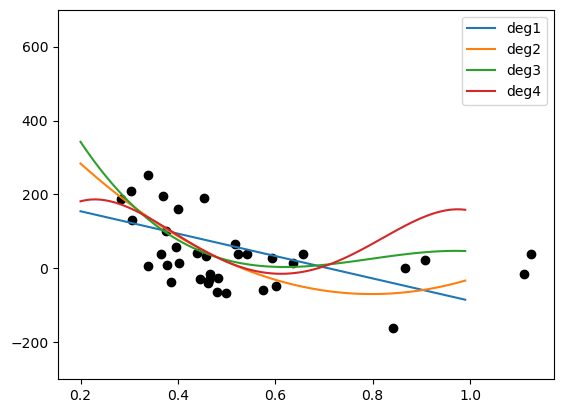

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ time_rel', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ time_rel * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ time_rel * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()


## LOG PRED PLOT

/tmp/ipykernel_2747101/38719194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/38719194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


36
36
36


[]

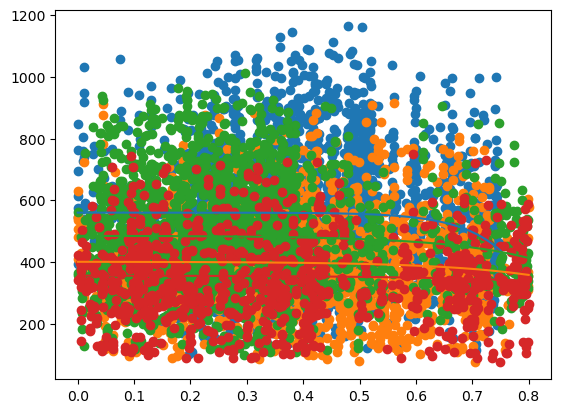

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50




def func(x, a, b, c):
    return a  + (b * np.exp(-x/c))

c = 0
f = 0
g = 0

for name, Subject in daf_c.groupby('Id'):
    c = c +1

    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values

      
    popt, pcov = curve_fit(func, x, y)
    g = g + 1
    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef = 1/popt[1]
    #age = Subject['sAge'].unique()[0]
    #plt.scatter(age,coef, color='black')

    f = f + 1
    #print(Subject['sAge'].unique()[0])
    #print(coef)

    if coef < -1:
        plt.scatter(Subject.time_rel.values,Subject.Slope.values)
        plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    
    
print(c)
print(f)
print(g)
    
plt.plot()

# NO BINS MODEL

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c.head()

/tmp/ipykernel_2747101/2859326843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2859326843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


index   Wave     Start  NegPeak  MidCrossing  PosPeak      End  \
47  2831880  12769  0.673000  2423.08      2423.34  2423.57  2423.91   
48  2830582  11471  0.679381  2446.06      2446.33  2446.52  2447.30   
49  2833475  14364  0.679381  2446.04      2446.28  2446.48  2446.75   
50  2835266  16155  0.679381  2446.03      2446.27  2446.47  2446.75   
51  2836802  17691  0.679381  2446.02      2446.25  2446.47  2446.79   

    Duration  ValNegPeak  ValPosPeak         PTP       Slope  Frequency  \
47      1.11  -46.707747   32.177395   78.885141  303.404390   0.900901   
48      1.53  -89.754462   38.805616  128.560078  476.148436   0.653595   
49      0.98 -117.820316   70.414380  188.234695  784.311231   1.020408   
50      0.98 -111.116778   73.118567  184.235346  767.647273   1.020408   
51      1.02  -55.017271   42.728858   97.746129  424.983169   0.980392   

    Stage Channel  IdxChannel Group Subject Session    Age Machine  \
47      3      F3           7     C     C02       1  22.91       O   
48      3      F7           6     C     C02       1  22.91       O   
49      3      Fz           8     C     C02       1  22.91       O   
50      3      F4           9     C     C02       1  22.91       O   
51      3      F8          10     C     C02       1  22.91       O   

   ConfArousal Position  N3_times  time_rel     Id    sAge  
47           0        F     0.673  0.000000  C02_1  0.4582  
48           0        F     0.673  0.006381  C02_1  0.4582  
49           0        F     0.673  0.006381  C02_1  0.4582  
50           0        F     0.673  0.006381  C02_1  0.4582  
51           0        F     0.673  0.006381  C02_1  0.4582

(array([7629., 2848., 7436., 3114., 9113., 7836.,    0., 3870., 9012.,
        2762.,  492., 3834., 3674.,  902.,  466., 2500., 1130., 1701.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   88.,
         419.,    0.,  256.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1803.]),
 array([0.284  , 0.30505, 0.3261 , 0.34715, 0.3682 , 0.38925, 0.4103 ,
        0.43135, 0.4524 , 0.47345, 0.4945 , 0.51555, 0.5366 , 0.55765,
        0.5787 , 0.59975, 0.6208 , 0.64185, 0.6629 , 0.68395, 0.705  ,
        0.72605, 0.7471 , 0.76815, 0.7892 , 0.81025, 0.8313 , 0.85235,
        0.8734 , 0.89445, 0.9155 , 0.93655, 0.9576 , 0.97865, 0.9997 ,
        1.02075, 1.0418 , 1.06285, 1.0839 , 1.10495, 1.126  ]),
 <BarContainer object of 40 artists>)

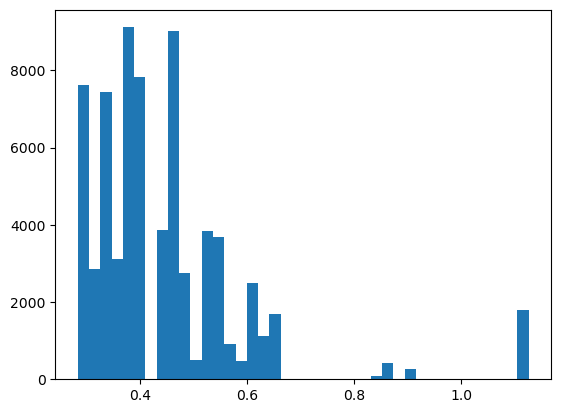

In [ ]:
plt.hist(daf_c['sAge'],40)

# UP TO deg 5

In [ ]:


model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2) + I(sAge^3) + I(sAge^4) + I(sAge^5)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2)+I(sAge^3)+I(sAge^4)+I(sAge^5))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 70885	 Groups: {'Subject:Session': 36.0}

Log-likelihood: -468538.719 	 AIC: 937105.439

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   2783.254   52.757
Residual                      32268.013  179.633

No random effect correlations specified

Fixed effects:

                        Estimate         2.5_ci        97.5_ci             SE  \
(Intercept)           545.230148   -4205.704435    5296.164730    2423.990757   
time_rel              650.151609   -1359.763086    2660.066304    1025.485525   
sAge                 2439.862933  -40785.782097   45665.507963   22054.305779   
I(sAge^2)          -18231.543279 -168347.025651  131883.939093   76590.939199   
I(sAge^3)           44263.778946 -204135.601478  292663.159371  126736.706585   
I(s

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-182.42663567,   -9.98758106,  298.17521341, ...,   79.22585185,
         53.6560655 ,  190.42256289])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

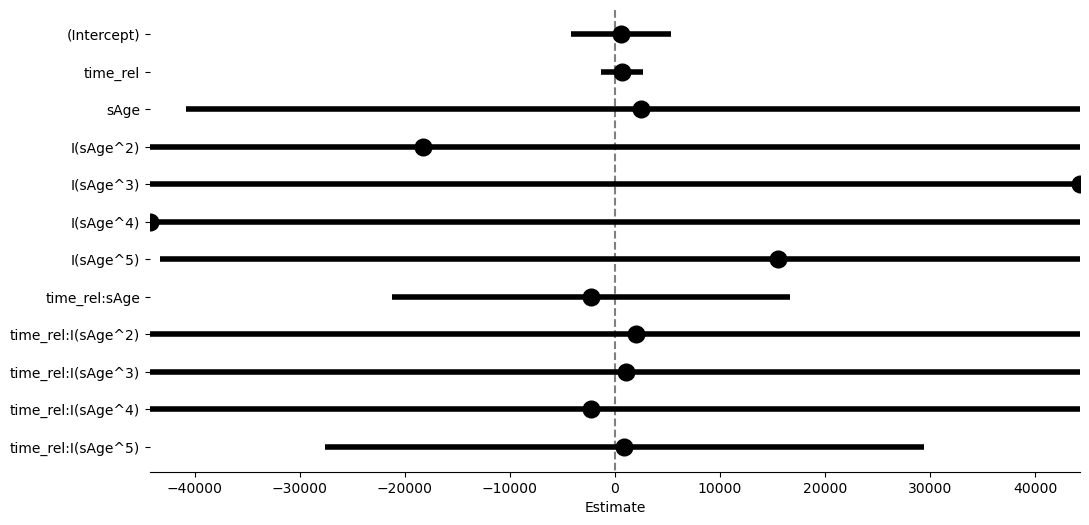

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)

    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


ValueError: Length of values (70885) does not match length of index (15362)

<Figure size 1000x600 with 0 Axes>

# Up to 2 deg BOTH

In [ ]:
model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2)) + I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2))+I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102381.231 	 AIC: 204784.462

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3953.781   62.879
Residual                      36005.746  189.752

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   305.326359  -195.244724   805.897442   
time_rel                      -28.407445 -1186.611038  1129.796147   
sAge                           82.758625 -1890.453768  2055.971018   
I(sAge^2)                     148.229150 -1690.067729  1986.526028   
I(sqrt(time_rel))             813.992976  -606.018835  2234.004788   
time_rel:sAge                -603.437313 -5307.231487  4100.3568

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-247.15359379,  -48.63753464,   16.24605027, ...,  338.3323455 ,
        -76.30385387, -163.44301389])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

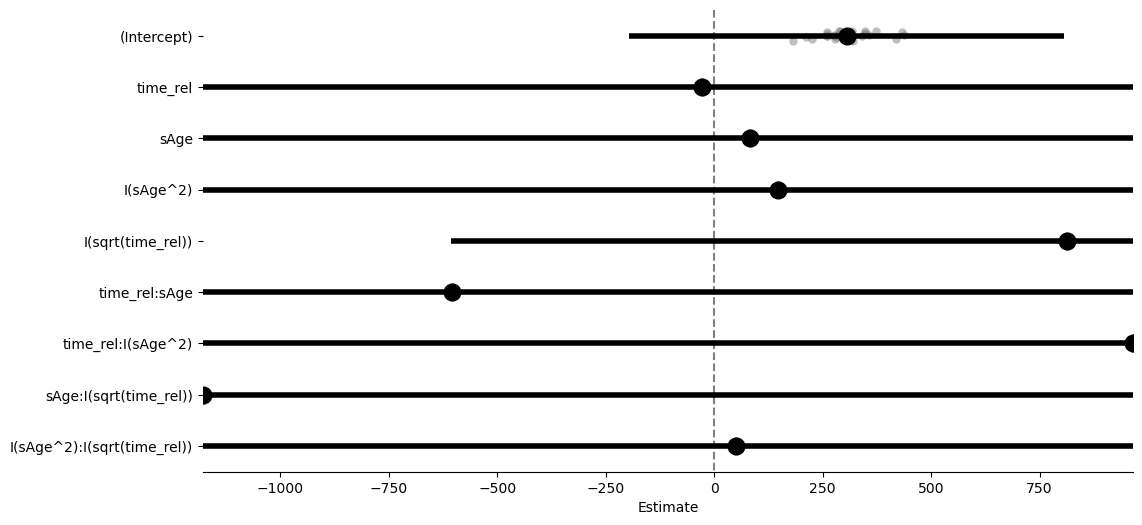

In [ ]:
model_sq.plot_summary()

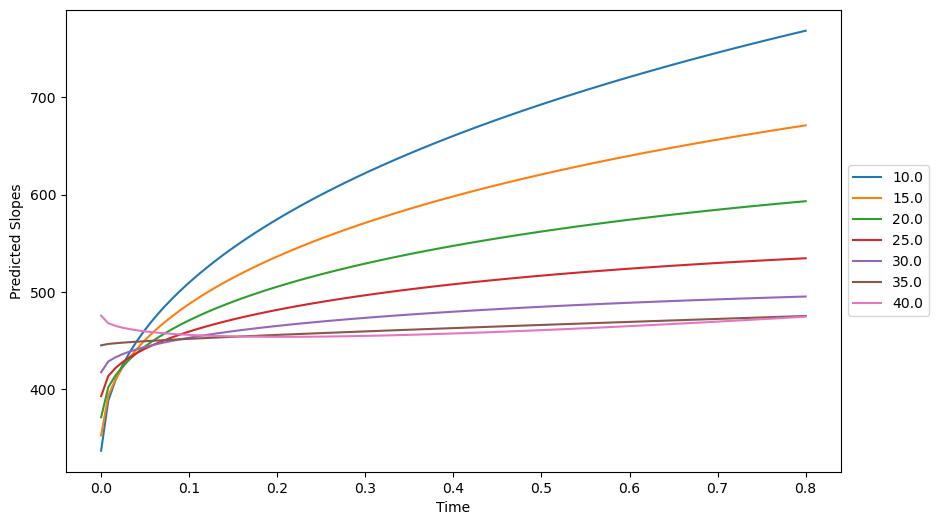

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


# SQRT 5 Deg BOTH

In [ ]:


model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2) +  I(sAge^3)) + time_rel * (sAge + I(sAge^2) + I(sAge^3)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2)+I(sAge^3))+time_rel*(sAge+I(sAge^2)+I(sAge^3))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102349.974 	 AIC: 204727.949

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3606.192   60.052
Residual                      36006.367  189.753

No random effect correlations specified

Fixed effects:

                                 Estimate        2.5_ci        97.5_ci  \
(Intercept)                     36.922543  -1799.604734    1873.449820   
I(sqrt(time_rel))             4522.657768   -701.952485    9747.268022   
sAge                          1904.851570  -9224.171641   13033.874781   
I(sAge^2)                    -3669.305727 -24993.713699   17655.102246   
I(sAge^3)                     2442.506488 -10357.671495   15242.684472   
time_rel            

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-258.63390099,  -57.65674197,   10.43682056, ...,  336.66618106,
        -77.97283668, -165.11606538])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

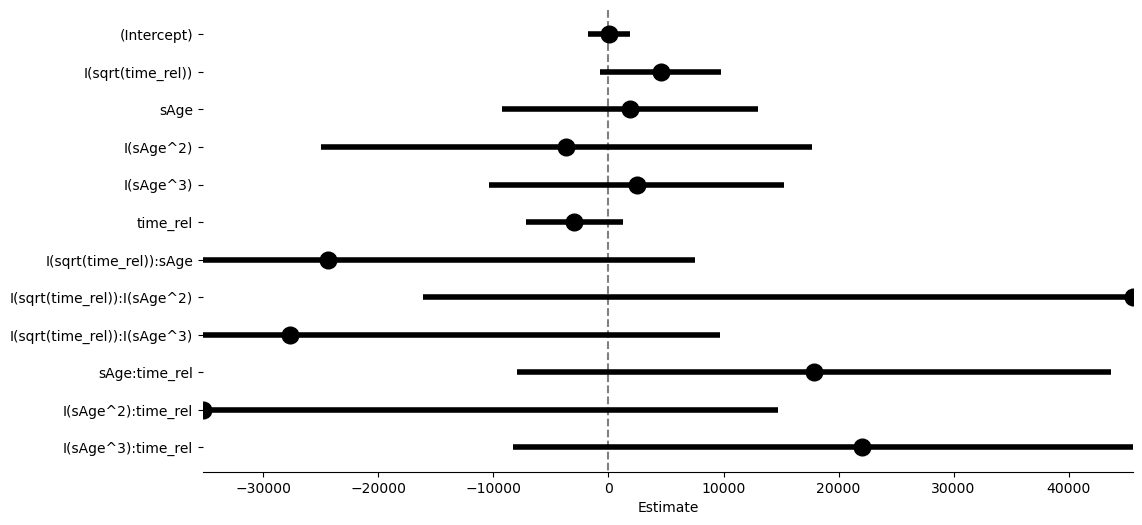

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    

ValueError: operands could not be broadcast together with shapes (15362,) (123921,) 

<Figure size 1000x600 with 0 Axes>

# SQRT deg 2

In [ ]:
model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals

Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 123921	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -818610.531 	 AIC: 1637237.061

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   4269.829   65.344
Residual                      31984.732  178.843

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   332.977855    58.379422   607.576289   
I(sqrt(time_rel))             644.881553   550.828292   738.934814   
sAge                           69.927264  -975.555671  1115.410200   
I(sAge^2)                     -11.091886  -945.498875   923.315104   
I(sqrt(time_rel)):sAge      -1453.831688 -1854.669336 -1052.994040   
I(sqrt(time_rel)):I(sAge^2)   913.942258   505.618396  1322.266121   

                 

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([  96.03910818,  119.93726911, -146.7354911 , ..., -129.03346606,
       -166.11564097, -278.91066559])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

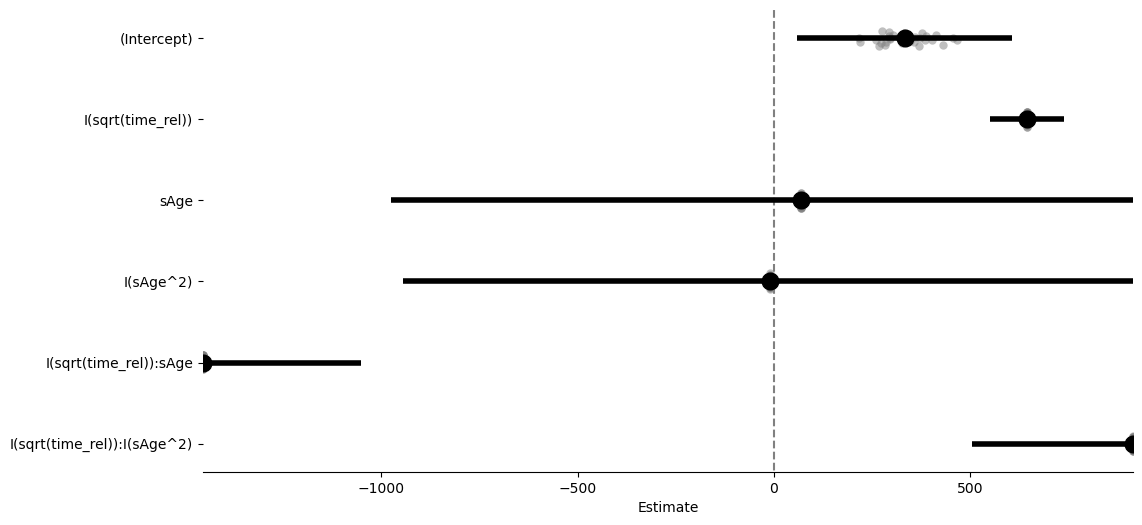

In [ ]:
model_sq.plot_summary()

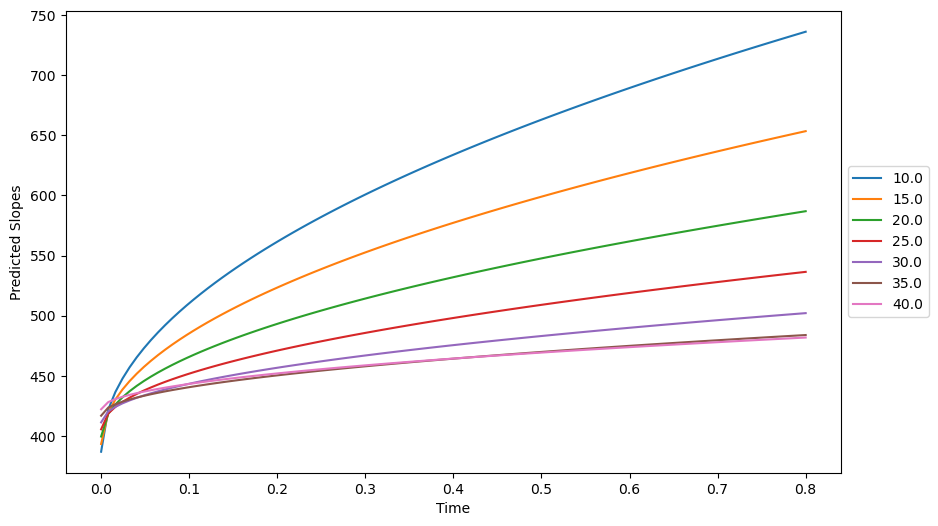

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   